### IMPORTING PACKAGES

In [34]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec #Word2Vec is mostly used for huge datasets

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/soumavadey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/soumavadey/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/soumavadey/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/soumavadey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading Data

In [36]:
#you can download the data from https://www.kaggle.com/c/nlp-getting-started/data
import os
os.getcwd()
df_train=pd.read_csv('input/train.csv')
print(df_train.shape)
df_train[df_train['target'] == 0]    #target = 0 Non-disaster tweets
#df_train[df_train['target'] == 1]     #target = 1 Disaster tweets

(7613, 5)


,id,keyword,location,text,target
15,23,NaN,NaN,What's up man?,0
16,24,NaN,NaN,I love fruits,0
17,25,NaN,NaN,Summer is lovely,0
18,26,NaN,NaN,My car is so fast,0
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0
...,...,...,...,...,...
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0
7582,10834,wrecked,NaN,Cramer: Iger's 3 words that wrecked Disney's s...,0
7584,10837,NaN,NaN,These boxes are ready to explode! Exploding Ki...,0
7587,10841,NaN,NaN,Sirens everywhere!,0


## EDA

0    4342
1    3271
Name: target, dtype: int64


/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='target'>

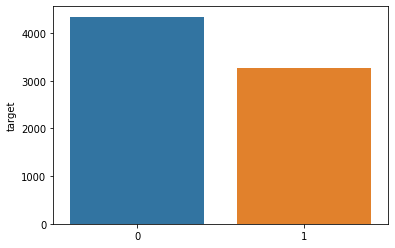

In [37]:
# CLASS DISTRIBUTION
#if dataset is balanced or not
x=df_train['target'].value_counts()
print(x)
sns.barplot(x.index,x)

In [38]:
#Missing values
df_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [39]:
#1. WORD-COUNT
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
print(df_train[df_train['target']==1]['word_count'].mean()) #Disaster tweets
print(df_train[df_train['target']==0]['word_count'].mean()) #Non-Disaster tweets
#Disaster tweets are more wordy than the non-disaster tweets
df_train[df_train['target'] == 0]['word_count'].max()

#2. CHARACTER-COUNT
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
print(df_train[df_train['target']==1]['char_count'].mean()) #Disaster tweets
print(df_train[df_train['target']==0]['char_count'].mean()) #Non-Disaster tweets
#Disaster tweets are longer than the non-disaster tweets

#3. UNIQUE WORD-COUNT
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
print(df_train[df_train['target']==1]['unique_word_count'].mean()) #Disaster tweets
print(df_train[df_train['target']==0]['unique_word_count'].mean()) #Non-Disaster tweets

15.167532864567411
14.704744357438969
108.11342097217977
95.70681713496084
14.664934270865178
14.09649930907416


In [40]:
df_train.head()

,id,keyword,location,text,target,word_count,char_count,unique_word_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,69,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,38,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,133,20
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,65,8
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,88,15


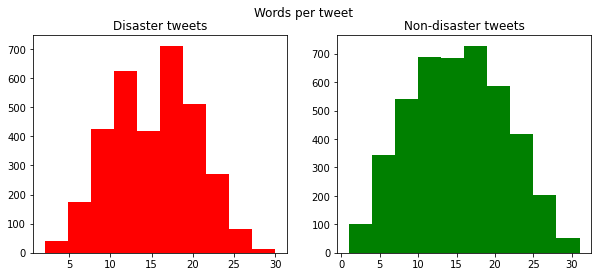

In [41]:
#Plotting word-count per tweet
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df_train[df_train['target']==1]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Disaster tweets')
train_words=df_train[df_train['target']==0]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Non-disaster tweets')
fig.suptitle('Words per tweet')
plt.show()

## PRE-PROCESSING

In [42]:
#1. Common text preprocessing
text = "   This is a message to be cleaned for testing. It may involve some things like: <br>, ?, :, ''  adjacent spaces and tabs     .  "

#convert to lowercase and remove punctuations and characters and then strip
def preprocess(text):
    text = text.lower() #lowercase text
    text=text.strip()  #get rid of leading/trailing whitespace 
    text=re.compile('<.*?>').sub('', text) #Remove HTML tags/markups
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  #Replace punctuation with space. Careful since punctuation can sometime be useful
    text = re.sub('\s+', ' ', text)  #Remove extra space and tabs
    text = re.sub(r'\[[0-9]*\]',' ',text) #[0-9] matches any digit (0 to 10000...)
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) #matches any digit from 0 to 100000..., \D matches non-digits
    text = re.sub(r'\s+',' ',text) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace 
    
    return text

text=preprocess(text)
print(text)  #text is a string

this is a message to be cleaned for testing it may involve some things like adjacent spaces and tabs


In [43]:
#3. LEXICON-BASED TEXT PROCESSING EXAMPLES
 
#1. STOPWORD REMOVAL 
#example “a”, “the”, “is”, “are”

def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

text=stopword(text)
print(text)

message cleaned testing may involve things like adjacent spaces tabs


In [44]:
#2. STEMMING

# Initialize the stemmer
snow = SnowballStemmer('english')
def stemming(string):
    a=[snow.stem(i) for i in word_tokenize(string) ]
    return " ".join(a)
text=stemming(text)
print(text)


messag clean test may involv thing like adjac space tab


In [45]:
#3. LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
# Full list is available here: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

text = lemmatizer(text)
print(text)

messag clean test may involv thing like adjac space tab


In [46]:
#FINAL PREPROCESSING
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

df_train['clean_text'] = df_train['text'].apply(lambda x: finalpreprocess(x))
df_train=df_train.drop(columns=['word_count','char_count','unique_word_count'])
df_train.head()

,id,keyword,location,text,target,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,get sent photo ruby alaska smoke wildfires pou...


### TRAIN TEST SPLITTING OF LABELLED DATASET

In [49]:
#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION
 
# Input: "reviewText", "rating" and "time"
# Target: "log_votes"
X_train, X_val, y_train, y_val = train_test_split(df_train["clean_text"],
                                                  df_train["target"],
                                                  test_size=0.2,
                                                  shuffle=True)
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  #for word2vec
X_val_tok= [nltk.word_tokenize(i) for i in X_val]      #for word2vec

#TF-IDF
# Convert x_train to vector since model can only run on numbers and not words- Fit and transform
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) #tfidf runs on non-tokenized sentences unlike word2vec
# Only transform x_test (not fit and transform)
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val) #Don't fit() your TfidfVectorizer to your test data: it will 
#change the word-indexes & weights to match test data. Rather, fit on the training data, then use the same train-data-
#fit model on the test data, to reflect the fact you're analyzing the test data only based on what was learned without 
#it, and the have compatible
print(X_train_vectors_tfidf)

#Word2vec
# Fit and transform
#modelw = MeanEmbeddingVectorizer(w2v)
#X_train_vectors_w2v = modelw.transform(X_train_tok)
#X_val_vectors_w2v = modelw.transform(X_val_tok)

  (0, 5803)	0.19810480024953966
  (0, 14307)	0.2539418631495494
  (0, 5684)	0.14431664138884118
  (0, 4811)	0.25038270059133405
  (0, 9649)	0.20904258689979885
  (0, 8467)	0.13686653009055327
  (0, 8633)	0.16616022463401542
  (0, 3250)	0.26763879906933996
  (0, 8985)	0.5248629314195754
  (0, 10930)	0.48844746491508145
  (0, 3528)	0.29105386568113917
  (0, 5441)	0.2287003625233527
  (1, 3017)	0.49959349388469504
  (1, 5605)	0.47977901623350555
  (1, 1543)	0.7212616976175101
  (2, 6600)	0.37601531392629767
  (2, 6217)	0.45124882881472933
  (2, 10937)	0.45124882881472933
  (2, 1360)	0.38858598869494565
  (2, 15104)	0.31102555612503086
  (2, 1693)	0.45124882881472933
  (3, 13515)	0.34291202212506194
  (3, 16537)	0.3497163022725425
  (3, 1485)	0.2694178326483455
  (3, 4634)	0.2706272356580399
  :	:
  (6087, 4517)	0.257736451853675
  (6087, 9340)	0.2495159201822701
  (6087, 1620)	0.2809538558482358
  (6087, 993)	0.250272583387669
  (6087, 3447)	0.2713830167980525
  (6087, 5598)	0.26150585320

### Building ML models (Text-classification)

#### LR (tf-idf)

              precision    recall  f1-score   support

           0       0.80      0.83      0.82       879
           1       0.76      0.72      0.74       644

    accuracy                           0.78      1523
   macro avg       0.78      0.77      0.78      1523
weighted avg       0.78      0.78      0.78      1523

[[730 149]
 [181 463]]
[[730 149]
 [181 463]]


<AxesSubplot:>

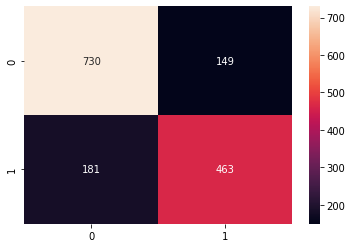

In [51]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)

#lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
#lr_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
#y_predict = lr_tfidf.predict(X_val_vectors_tfidf)
#y_prob = lr_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]
 

print(classification_report(y_val,y_predict))
print(confusion_matrix(y_val, y_predict))
cf_matrix = confusion_matrix(y_val, y_predict)
print(cf_matrix)
sns.heatmap(cf_matrix, annot=True, fmt="d")
 
#fpr, tpr, thresholds = roc_curve(y_val, y_prob)
#roc_auc = auc(fpr, tpr)
#print('AUC:', roc_auc)  

### TESTING THE MODEL ON UNLABELLED DATASET

In [52]:
#Testing it on new dataset with the best model
df_test=pd.read_csv('input/test.csv')  #reading the data
df_test['clean_text'] = df_test['text'].apply(lambda x: finalpreprocess(x)) #preprocess the data
X_test=df_test['clean_text'] 
X_vector=tfidf_vectorizer.transform(X_test) #converting X_test to vector
y_predict = lr_tfidf.predict(X_vector)      #use the trained model on X_vector
y_prob = lr_tfidf.predict_proba(X_vector)[:,1]
df_test['predict_prob']= y_prob
df_test['target']= y_predict
print(df_test.head(50))
final=df_test[['id','target']].reset_index(drop=True)
final.to_csv('submission.csv')

     id     keyword                        location  \
0     0         NaN                             NaN   
1     2         NaN                             NaN   
2     3         NaN                             NaN   
3     9         NaN                             NaN   
4    11         NaN                             NaN   
5    12         NaN                             NaN   
6    21         NaN                             NaN   
7    22         NaN                             NaN   
8    27         NaN                             NaN   
9    29         NaN                             NaN   
10   30         NaN                             NaN   
11   35         NaN                             NaN   
12   42         NaN                             NaN   
13   43         NaN                             NaN   
14   45         NaN                             NaN   
15   46      ablaze                          London   
16   47      ablaze  Niall's place | SAF 12 SQUAD |   
17   51   